# Orange Team CQ#1.7

**Query:** What genes show high phenotypic similarity to the 11 Fanconi Anemia core complex genes (set FA-core)?

## Workflow:


**Input:** NCBIGene identifiers for 11 human FA-core genes

1. Retrieve orthologs of FA-core genes and add to human FA-core set
2. Retrieve phenotype terms associated genes in this set
3. Execute PhenoSim analysis to return ranked list of phenotypically similar genes
4. Select subset of genes meeting some defined threshhold
5. Retrieve human orthologs of all non-human genes in this set

**Output:** GeneSetQ7 (phenotypically similar human genes based on cross-species PhenoSim analysis)

### Contributors:

- Greg Stupp
- Tong Shu Li
- Michael Yu

## Part 1

Retrieve orthologs of FA-core genes and add to human FA-core set.

In [1]:
import requests
from itertools import chain
from io import StringIO
from tqdm import tqdm
import numpy as np

from scipy.sparse import coo_matrix
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
gene_list = "https://raw.githubusercontent.com/NCATS-Tangerine/cq-notebooks/" \
            "master/OrangeQ1.5_Regulatory_Motif_Signature/FA_NCBIGene_symbol.txt"
df = pd.read_csv(gene_list, sep='\t', names=['ncbi','gene'])
df.head()

,ncbi,gene
0,NCBIGene:2175,FANCA
1,NCBIGene:2187,FANCB
2,NCBIGene:2176,FANCC
3,NCBIGene:2178,FANCE
4,NCBIGene:2188,FANCF


### Get Wikidata ids for these HGNC symbols from wikidata using garbanzo

In [3]:
api_url = "http://garbanzo.sulab.org/"
c = ' '.join([x.upper() for x in df.ncbi])
endpoint = "exactmatches/"
params = {'c': c}
r = requests.get(api_url + endpoint, params=params)
qids = [x for x in r.json() if "wd" in x]

### Get all orthologs from wikidata using garbanzo

In [4]:
endpoint = 'statements/'
params = {'c': ','.join(qids[:12])}
r = requests.get(api_url + endpoint, params=params)
d = r.json()
params = {'c': ','.join(qids[12:])}
r = requests.get(api_url + endpoint, params=params)
d.extend(r.json())

In [5]:
ortholog_statements = [x for x in d if x['predicate']['name'] == "ortholog"]
ortholog_qids = set(chain(*[(x['object']['id'], x['subject']['id']) for x in ortholog_statements]))
print(len(ortholog_qids))

103


### Convert to NCBI gene ids

In [6]:
endpoint = "exactmatches/"
params = {'c': ' '.join(ortholog_qids)}
r = requests.get(api_url + endpoint, params=params)
ncbi = [x for x in r.json() if "NCBI" in x]

In [89]:
fa_ncbi = set([x.replace("NCBIGENE", "NCBIGene") for x in ncbi])
fa_ncbi

{'NCBIGene:100001169',
 'NCBIGene:100360594',
 'NCBIGene:100534597',
 'NCBIGene:12190',
 'NCBIGene:14088',
 'NCBIGene:177914',
 'NCBIGene:19361',
 'NCBIGene:199990',
 'NCBIGene:2072',
 'NCBIGene:2175',
 'NCBIGene:2177',
 'NCBIGene:2178',
 'NCBIGene:2187',
 'NCBIGene:233826',
 'NCBIGene:293452',
 'NCBIGene:305600',
 'NCBIGene:312641',
 'NCBIGene:327322',
 'NCBIGene:360465',
 'NCBIGene:360588',
 'NCBIGene:362678',
 'NCBIGene:394241',
 'NCBIGene:406487',
 'NCBIGene:497672',
 'NCBIGene:497976',
 'NCBIGene:499966',
 'NCBIGene:501552',
 'NCBIGene:550258',
 'NCBIGene:55120',
 'NCBIGene:55215',
 'NCBIGene:553395',
 'NCBIGene:559470',
 'NCBIGene:565685',
 'NCBIGene:5888',
 'NCBIGene:5889',
 'NCBIGene:60534',
 'NCBIGene:672',
 'NCBIGene:675',
 'NCBIGene:67513',
 'NCBIGene:688314',
 'NCBIGene:691105',
 'NCBIGene:692125',
 'NCBIGene:692127',
 'NCBIGene:71885',
 'NCBIGene:72775',
 'NCBIGene:768152',
 'NCBIGene:79728',
 'NCBIGene:83990',
 'NCBIGene:84464',
 'NCBIGene:856831'}

## Part 2: Retrieve phenotype terms associated with all genes

In [8]:
# get phenotypes associated with all human genes
url = "https://api.monarchinitiative.org/api/mart/gene/phenotype/NCBITaxon:9606"
d = requests.get(url).json()

In [9]:
phenos = {x['subject']:set(x['objects']) for x in d}

In [10]:
list(phenos.items())[2]

('NCBIGene:549',
 {'HP:0000020',
  'HP:0000252',
  'HP:0000648',
  'HP:0000736',
  'HP:0000750',
  'HP:0001250',
  'HP:0001251',
  'HP:0001259',
  'HP:0001260',
  'HP:0001263',
  'HP:0001270',
  'HP:0001285',
  'HP:0001332',
  'HP:0001347',
  'HP:0001508',
  'HP:0001942',
  'HP:0001943',
  'HP:0002059',
  'HP:0002073',
  'HP:0002134',
  'HP:0002240',
  'HP:0002305',
  'HP:0002352',
  'HP:0002373',
  'HP:0002510',
  'HP:0003535',
  'HP:0100543'})

In [11]:
len(phenos)

4946

In [12]:
##  and then add in the phenotypes of other non-human genes

In [13]:
def get_phenotypes(gene_id):
    """Query Monarch to determine the phenotypes associated with a NCBI gene id."""
    url = "https://api.monarchinitiative.org/api/bioentity/gene/{}/phenotypes/".format(gene_id)
    res = requests.get(url)
    return set(res.json()["objects"])

In [14]:
other_genes = set(fa_ncbi)-set(df.ncbi)
print(len(other_genes))
for gene in other_genes:
    phenos[gene] = get_phenotypes(gene)

35


In [15]:
print(len([x for x in other_genes if phenos[x]]))

8


In [16]:
phenos = {k:v for k,v in phenos.items() if v}

In [17]:
## 35 extra non-human genes, 8 have one or more phenotypes

## Part 3: Execute PhenoSim analysis to return ranked list of phenotypically similar genes

### Create a similarity matrix of all_genes by all_genes based on a Jaccard similarity of the associated phenotype sets

In [18]:
all_phenotypes = sorted(np.unique(list(chain(*phenos.values()))))
phenotype_idx = {b : a for a, b in enumerate(all_phenotypes)}
all_genes = sorted(phenos.keys())
gene_idx = {b : a for a, b in enumerate(all_genes)}

In [19]:
def get_similarity(x,y):
    x_set = phenos[x]
    y_set = phenos[y]
    return len(x_set & y_set) / float(len(x_set | y_set))

data_ij = [(get_similarity(x,y), gene_idx[x], gene_idx[y]) for x in tqdm(all_genes, mininterval=5) for y in all_genes]

100%|██████████| 4954/4954 [01:20<00:00, 61.38it/s]


In [20]:
data, i_list, j_list = zip(*data_ij)
data, i_list, j_list = np.array(data), np.array(i_list), np.array(j_list)
g2g = coo_matrix((data, (i_list, j_list)), shape=(len(all_genes), len(all_genes)))
g2g = g2g.toarray()

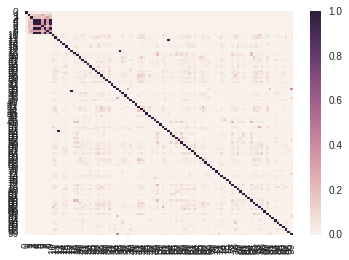

In [24]:
sns.heatmap(g2g[::50,::50])

In [38]:
values=list(chain(*[list(x) for x in g2g]))
len(values)

24542116

In [ ]:
# plot of distribution of ALL similarities

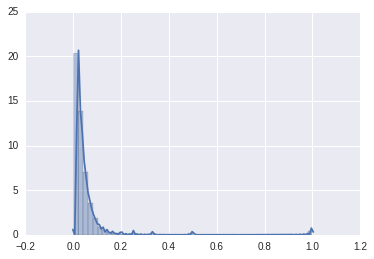

In [39]:
sns.distplot([x for x in values if x])

### Identify all genes that have a Jaccard similarity  > 0.2 with at least one of the FA genes

In [40]:
# sanity check. gene vs itself should be 1
g2g[gene_idx['NCBIGene:2175']][gene_idx['NCBIGene:2175']]

1.0

In [48]:
# one of the FA genes vs all genes
this_gene_sim = set(np.array(all_genes)[g2g[gene_idx['NCBIGene:2175']] > 0.2])
this_gene_sim

{'NCBIGene:10459',
 'NCBIGene:2072',
 'NCBIGene:2175',
 'NCBIGene:2176',
 'NCBIGene:2177',
 'NCBIGene:2178',
 'NCBIGene:2187',
 'NCBIGene:2188',
 'NCBIGene:2189',
 'NCBIGene:29089',
 'NCBIGene:55120',
 'NCBIGene:55215',
 'NCBIGene:57697',
 'NCBIGene:5888',
 'NCBIGene:5889',
 'NCBIGene:675',
 'NCBIGene:7516',
 'NCBIGene:79728',
 'NCBIGene:83990',
 'NCBIGene:84464'}

In [49]:
# and some of them are non FA genes!
this_gene_sim - set(fa_ncbi)

{'NCBIGene:10459',
 'NCBIGene:2176',
 'NCBIGene:2188',
 'NCBIGene:2189',
 'NCBIGene:29089',
 'NCBIGene:57697',
 'NCBIGene:7516'}

In [101]:
similar_d = dict()
for g in fa_ncbi:
    if g in gene_idx:
        this_sim = set(list(np.array(all_genes)[g2g[gene_idx[g]] > 0.2]))
        similar_d[g] = this_sim

In [102]:
len(similar_d)

22

In [105]:
similar_d

{'NCBIGene:12190': {'NCBIGene:12190'},
 'NCBIGene:14088': {'NCBIGene:14088'},
 'NCBIGene:177914': {'NCBIGene:177914'},
 'NCBIGene:19361': {'NCBIGene:19361'},
 'NCBIGene:2072': {'NCBIGene:10459',
  'NCBIGene:1643',
  'NCBIGene:2068',
  'NCBIGene:2071',
  'NCBIGene:2072',
  'NCBIGene:2073',
  'NCBIGene:2175',
  'NCBIGene:2176',
  'NCBIGene:2177',
  'NCBIGene:2178',
  'NCBIGene:2187',
  'NCBIGene:2188',
  'NCBIGene:2189',
  'NCBIGene:29089',
  'NCBIGene:55120',
  'NCBIGene:55215',
  'NCBIGene:57697',
  'NCBIGene:5888',
  'NCBIGene:5889',
  'NCBIGene:675',
  'NCBIGene:7507',
  'NCBIGene:7508',
  'NCBIGene:7516',
  'NCBIGene:79728',
  'NCBIGene:83990',
  'NCBIGene:84464'},
 'NCBIGene:2175': {'NCBIGene:10459',
  'NCBIGene:2072',
  'NCBIGene:2175',
  'NCBIGene:2176',
  'NCBIGene:2177',
  'NCBIGene:2178',
  'NCBIGene:2187',
  'NCBIGene:2188',
  'NCBIGene:2189',
  'NCBIGene:29089',
  'NCBIGene:55120',
  'NCBIGene:55215',
  'NCBIGene:57697',
  'NCBIGene:5888',
  'NCBIGene:5889',
  'NCBIGene:675'

In [103]:
all_similar_genes = set(chain(*similar_d.values()))
print(len(all_similar_genes))

47


In [104]:
# 25 of the 47 are not in the FA set or orthologs
# # genes that are phenotypically similar to FA genes (but not including the FA genes or FA orthologs)
similar = all_similar_genes-set(fa_ncbi)
len(similar)

25

## Step 5: Retrieve human orthologs of all non-human genes in this set

In [57]:
def is_gene_human(gene_id):
    url = "https://api.monarchinitiative.org/api/bioentity/gene/{}".format(gene_id)
    res = requests.get(url)
    taxon = res.json()['taxon']['id']
    return True if taxon == "NCBITaxon:9606" else False

In [58]:
def query_human_orthologs(gene_id):
    """Query Monarch to determine the human orthologs of a gene."""
    
    url = "https://api.monarchinitiative.org/api/bioentity/gene/{}/homologs/".format(gene_id)
    res = requests.get(url)
    d = res.json()
    return [x['object']['id'] for x in d['associations'] if x['object']['taxon']['id'] == 'NCBITaxon:9606']

In [77]:
igh = {x:is_gene_human(x) for x in tqdm(similar)}


100%|██████████| 25/25 [00:23<00:00,  1.10it/s]


In [78]:
# all similar genes are human, so don't bother
set(igh.values())

{True}

In [66]:
#non_human = [x for x in all_similar_genes if not igh[x]]
#human_orthologs = {x:query_human_orthologs(x) for x in non_human}

## Output: GeneSetQ7 (phenotypically similar genes based on cross-species PhenoSim analysis)

In [79]:
similar

{'NCBIGene:10459',
 'NCBIGene:10481',
 'NCBIGene:11200',
 'NCBIGene:115795',
 'NCBIGene:1643',
 'NCBIGene:2048',
 'NCBIGene:2068',
 'NCBIGene:2071',
 'NCBIGene:2073',
 'NCBIGene:2176',
 'NCBIGene:2188',
 'NCBIGene:2189',
 'NCBIGene:29089',
 'NCBIGene:4477',
 'NCBIGene:4481',
 'NCBIGene:4683',
 'NCBIGene:5157',
 'NCBIGene:57697',
 'NCBIGene:5925',
 'NCBIGene:6041',
 'NCBIGene:60528',
 'NCBIGene:6928',
 'NCBIGene:7507',
 'NCBIGene:7508',
 'NCBIGene:7516'}